In [1]:
%%writefile ping_pong_2.cpp

#include <mpi.h>
#include "mpi.h"
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <unistd.h>
#include <vector>
#include <algorithm>
#include <cstdlib> 

using namespace std;

void add_to_passed_list(vector<int>& passed_list, int prank)
{
    passed_list[0]++; // update number of played players. 
    passed_list[passed_list[0]] = prank;
}

int send_to_process(vector<int>& passed_list, int psize)
{
    srand(time(NULL));
    vector<int> not_passed;

    for (int i = 0; i< psize;i++)
    {
        std::vector<int>::iterator it;
        it = find(passed_list.begin()+1,passed_list.end(), i);
        if (it == passed_list.end())
        {
            not_passed.push_back(i);
        }
    }
    
    if (not_passed.empty())
    {
         //cout << "All players passed the ball!" << endl;
         return 100;
    }
    else
    {        
        int rand_index = rand() % not_passed.size();
        return not_passed[rand_index];
    }

}

void print_array(vector<int>& arr, int N) {
    for (int i = 0; i < N; ++i)
        printf("%d ", arr[i]);
    printf("\n");
}

int main(int argc, char ** argv) 
{
    int psize;
    int prank;
    MPI_Status status;
    int ierr;
 
    double time_elapsed;

    ierr = MPI_Init(&argc, &argv);
    ierr = MPI_Comm_rank(MPI_COMM_WORLD, &prank);
    ierr = MPI_Comm_size(MPI_COMM_WORLD, &psize);
    time_elapsed = MPI_Wtime();
    
    vector<int> passed_list;
    passed_list.push_back(0); // number of played processors
    for (int i = 0; i < psize; i++)
    {
        passed_list.push_back(100); // played vector
    }

    if (prank == 0)
    {
        //init_players(not_passed,psize);
        
        add_to_passed_list(passed_list, prank);
        //print_array(passed_list, passed_list.size());

        int to_process = 1;
 
	      MPI_Ssend(&passed_list[0],psize+1, MPI_INT, 1, 13, MPI_COMM_WORLD);
    }
    else
    {
    	MPI_Recv(&passed_list[0],psize+1, MPI_INT, MPI_ANY_SOURCE, 13, MPI_COMM_WORLD, &status);
    	//print_array(passed_list, passed_list.size());
	    add_to_passed_list(passed_list, prank);
	
	    int to_process = send_to_process(passed_list, psize);
	    if (to_process != 100)
	    {
	        MPI_Ssend(&passed_list[0],psize+1, MPI_INT, to_process, 13, MPI_COMM_WORLD);
	    } 	
    }
 
    time_elapsed = MPI_Wtime() - time_elapsed;
    cout << time_elapsed << endl;
    
    ierr = MPI_Finalize();

    return 0;

}


Writing ping_pong_2.cpp


In [ ]:
!mpic++ ping_pong_2.cpp -o ping_pong_2

In [ ]:
!mpirun --allow-run-as-root -n 3 ./ping_pong_2 

0.00227287
0.00021435
0.00033832


In [ ]:
!rm ftime*

In [2]:
import matplotlib.pyplot as plt

iteration = {}
time = []
total_time = []
for i in range(2,7):
  iteration[f'{i}'] = []
  X = []
  for line in open(f'text_{i}.txt', 'r'):
    values = [float(s) for s in line.split()]
    X.append(values)

  result = 0
  for x in X:
    iteration[f'{i}'].append(x[0])
    result += x[0]
  total_time.append(result)
  result = result/len(X)
  time.append(result)

In [ ]:
iteration

{'2': [1.5079e-05, 3.2897e-05],
 '3': [1.8873e-05, 4.338e-05, 4.6607e-05],
 '4': [3.8876e-05, 5.2603e-05, 1.7816e-05, 2.5174e-05],
 '5': [4.4044e-05, 1.9284e-05, 2.761e-05, 5.963e-05, 4.8742e-05],
 '6': [1.7286e-05,
  5.231e-05,
  0.000130169,
  2.4727e-05,
  0.000169992,
  0.000142276]}

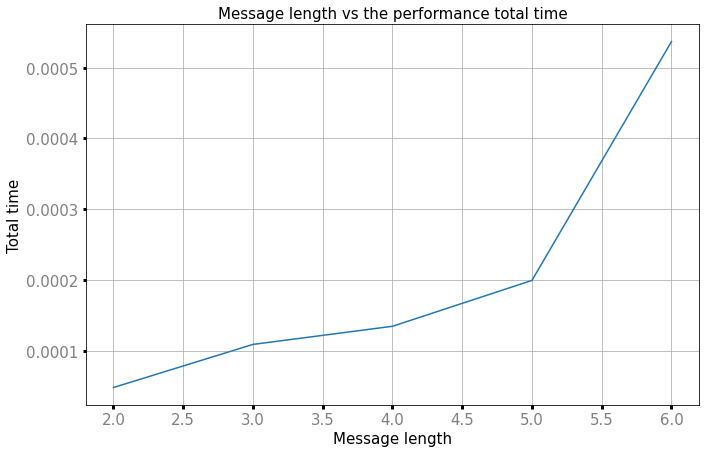

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(11,7))

plt.plot(np.arange(2,7), total_time)

plt.title('Message length vs the performance total time',fontsize=15)
plt.xlabel('Message length',fontsize=15)
plt.ylabel('Total time',fontsize=15)
plt.tick_params(labelcolor='gray', labelsize=15, width=3)
plt.grid()
plt.show()

In [8]:
import pandas as pd

dataset = { 'Size': np.arange(2,7),'# Iterations': np.arange(2,7), 'Total time': total_time, "Time per message": time}

result = pd.DataFrame(dataset)
result['Size'] = result['Size'] + 1
result['Bandwidth Mb/s'] = result['Size']/result['Total time'] * 1e-6
result

,Size,# Iterations,Total time,Time per message,Bandwidth Mb/s
0,3,2,0.000048,0.000024,0.062531
1,4,3,0.000109,0.000036,0.036744
2,5,4,0.000134,0.000034,0.037183
3,6,5,0.000199,0.000040,0.030104
4,7,6,0.000537,0.000089,0.013041
